In [18]:
import argparse
import os
import cv2
import numpy as np
import torch
from PIL import Image
import requests
from torchvision import models
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise, KPCA_CAM
)
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--device', type=str, default='cpu',
                        help='Torch device to use')
    parser.add_argument(
        '--image-path',
        type=str,
        default='./examples/both.png',
        help='Input image path')
    parser.add_argument('--aug-smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen-smooth',
        action='store_true',
        help='Reduce noise by taking the first principle component'
        'of cam_weights*activations')
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=[
                            'gradcam', 'hirescam', 'gradcam++',
                            'scorecam', 'xgradcam', 'ablationcam',
                            'eigencam', 'eigengradcam', 'layercam',
                            'fullgrad', 'gradcamelementwise', 'kpcacam'
                        ],
                        help='CAM method')

    parser.add_argument('--output-dir', type=str, default='output',
                        help='Output directory to save the images')
    args = parser.parse_args()
    
    if args.device:
        print(f'Using device "{args.device}" for acceleration')
    else:
        print('Using CPU for computation')

    return args


In [10]:
device="cuda"

In [11]:
methods = {
    "gradcam": GradCAM,
    "hirescam": HiResCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad,
    "gradcamelementwise": GradCAMElementWise,
    'kpcacam': KPCA_CAM
}

model = models.resnet50(pretrained=True).to(torch.device(device)).eval()



/media/sd-card-disk/miniconda3/envs/chimcla311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/sd-card-disk/miniconda3/envs/chimcla311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open("experiments/cars.jpg"))
from matplotlib.pyplot import imshow

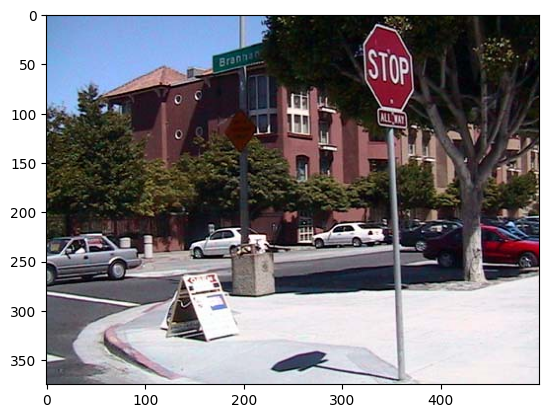

In [25]:
%matplotlib inline
imshow(image)

In [27]:
target_layers = [model.layer4]


rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(device)

In [30]:
targets = None

# Using the with statement ensures the context is freed, and you can
# recreate different CAM objects in a loop.
cam_algorithm = methods["gradcam"]
with cam_algorithm(model=model, target_layers=target_layers) as cam:

    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=True,
                        eigen_smooth=False)

    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

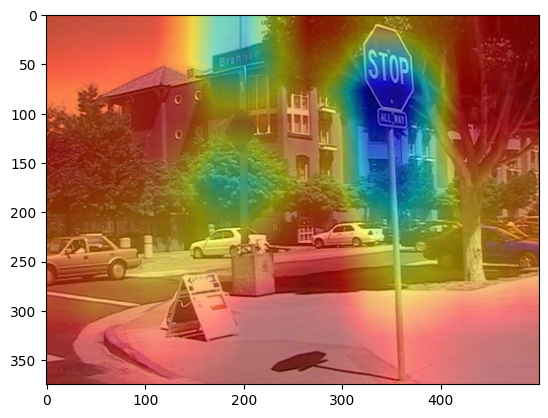

In [31]:
imshow(cam_image)

In [ ]:
if __name__ == '__main__':
    pass


    # Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
    
    target_layers = [model.layer4]

    rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]).to(args.device)

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [ClassifierOutputTarget(281)]
    # targets = [ClassifierOutputTarget(281)]
    targets = None

    # Using the with statement ensures the context is freed, and you can
    # recreate different CAM objects in a loop.
    cam_algorithm = methods[args.method]
    with cam_algorithm(model=model,
                       target_layers=target_layers) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=args.aug_smooth,
                            eigen_smooth=args.eigen_smooth)

        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, device=args.device)
    gb = gb_model(input_tensor, target_category=None)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    os.makedirs(args.output_dir, exist_ok=True)

    cam_output_path = os.path.join(args.output_dir, f'{args.method}_cam.jpg')
    gb_output_path = os.path.join(args.output_dir, f'{args.method}_gb.jpg')
    cam_gb_output_path = os.path.join(args.output_dir, f'{args.method}_cam_gb.jpg')

    cv2.imwrite(cam_output_path, cam_image)
    cv2.imwrite(gb_output_path, gb)
    cv2.imwrite(cam_gb_output_path, cam_gb)